In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import Sequential
from keras import preprocessing
from keras.layers import Normalization
from matplotlib import pyplot as plt
import zipfile
from shutil import copyfile
from time import time
import numpy as np
import random as python_random
import os
from pathlib import Path
import PIL
from PIL import Image
import statistics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
# seed initialization to get same results
np.random.seed(0)
python_random.seed(0)
tf.random.set_seed(0)

# Upload

In [3]:
# Link Google Drive account
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# Import file in the virtual machine
t0 = time()
# Transfer zip dataset to the current virtual machine
copyfile('/content/gdrive/MyDrive/Project_DeepLearning/flower_photos_divided.zip', 'flower_photos_divided.zip') # fonte e dove copiarlo
# Extract files 
zip = zipfile.ZipFile('flower_photos_divided.zip') #scompatta cartella zippata
zip.extractall() #invochiamo zip
zip.close() # necessario per accellerare le operazioni
print("File transfer completed in %0.3f seconds" % (time() - t0))

base_path = Path('flower_photos_divided/')

File transfer completed in 5.416 seconds


# Data



## Train and Validation 

In [5]:
# train dataset
train_dataset = keras.preprocessing.image_dataset_from_directory("flower_photos_divided/train", #assegniamo a variabile train dataset
                                                            image_size=(224,224), #dimesione standard   # ridimensionate alla stessa dimensione (stessa risoluzione). Per poter sfruttare il batch processing, le immagini vengono impilate in un unico tensore poiche alcuni livelli neurali funzionano in base ad una specifica cardinalità
                                                            batch_size=128,   # 32 immagini di input alla volta. più immagini, più l'apprendimento è stabile         
                                                            label_mode='categorical',
                                                            #subset='training',
                                                            #validation_split = 0.2,
                                                            shuffle=True,# Data shuffling (randomization of the instances order) is fundamental to ensure that each minibatch is representative of the whole set of classes
                                                            seed=1)
# 800 file (80%) verrano utilizzati per l'addestramento, mentre 200 per il validation

Found 2935 files belonging to 5 classes.


In [6]:
# validation dataset
val_dataset = keras.preprocessing.image_dataset_from_directory("flower_photos_divided/test", #assegniamo a variabile train dataset
                                                            image_size=(224,224), #dimesione standard   # ridimensionate alla stessa dimensione (stessa risoluzione). Per poter sfruttare il batch processing, le immagini vengono impilate in un unico tensore poiche alcuni livelli neurali funzionano in base ad una specifica cardinalità
                                                            batch_size=128,   # 32 immagini di input alla volta. più immagini, più l'apprendimento è stabile         
                                                            label_mode='categorical',
                                                            #subset='validation',
                                                            #validation_split = 0.2,
                                                            shuffle=False,
                                                            seed=1)
# 800 file (80%) verrano utilizzati per l'addestramento, mentre 200 per il validation

Found 735 files belonging to 5 classes.


## Data Augmentation

In [7]:
data_augmentation = keras.Sequential(
    [
     layers.RandomFlip("horizontal_and_vertical"),
     layers.RandomRotation(0.4),
     layers.RandomBrightness(factor= 0.4), # allowing the generator to randomly darken the image of 0.2 or 20%
     layers.RandomZoom(0.2),
     layers.RandomCrop(180,260),
     layers.Resizing(224,224),
     layers.Normalization()
    ]
)

# Model - Pretrained - BaseNet

In [8]:
num_classes = 5

In [17]:
# we set an early stopping
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)

#we save only the best model
checkpoint_filepath = 'gdrive/MyDrive/Project_DeepLearning/2_CNN_BaseNet'
mcp_save = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True, monitor='val_loss', mode='min')

In [11]:
# Download Base Model weights
base_net = keras.applications.MobileNetV2(input_shape=(224,224,3), weights='imagenet', include_top=False, pooling='avg')

9406464/9406464 [==============================] - 1s 0us/step


In [12]:
# Freezing the base model weights
base_net.trainable = False

In [14]:
# Explicit input layer
inputs = keras.Input((224,224,3))
#x = inputs
x = data_augmentation(inputs)

# Output of the base model
x = base_net(x)

# New intermediate fully-connected layer + ReLU
x = keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

outputs = keras.layers.Dense(num_classes, activation="softmax")(x)

base_net = keras.Model(inputs, outputs)

In [15]:
print(base_net.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       7         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dense_1 (Dense)             (None, 1024)              1311744   
                                                                 
 dense_2 (Dense)             (None, 5)                 5125      
                                                                 
Total params: 3,574,860
Trainable params: 1,316,869
Non-trainable params: 2,257,991
___________________________________________

## Compile & Training - Base.Net Model

In [16]:
# Compile the model for training
base_net.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy'])

In [18]:
# Model training
history = base_net.fit(train_dataset,
          epochs=80,
          validation_data=val_dataset,
          callbacks=[callback, mcp_save]);

Epoch 1/80
23/23 [==============================] - ETA: 0s - loss: 4.1373 - accuracy: 0.3032

23/23 [==============================] - 50s 2s/step - loss: 4.1373 - accuracy: 0.3032 - val_loss: 2.5936 - val_accuracy: 0.3007
Epoch 2/80
23/23 [==============================] - ETA: 0s - loss: 2.4493 - accuracy: 0.3857

23/23 [==============================] - 33s 1s/step - loss: 2.4493 - accuracy: 0.3857 - val_loss: 2.5442 - val_accuracy: 0.2898
Epoch 3/80
23/23 [==============================] - ETA: 0s - loss: 2.1699 - accuracy: 0.4395

23/23 [==============================] - 35s 1s/step - loss: 2.1699 - accuracy: 0.4395 - val_loss: 2.3190 - val_accuracy: 0.3986
Epoch 4/80
23/23 [==============================] - ETA: 0s - loss: 1.9847 - accuracy: 0.4654

23/23 [==============================] - 42s 2s/step - loss: 1.9847 - accuracy: 0.4654 - val_loss: 2.0291 - val_accuracy: 0.4041
Epoch 5/80
23/23 [==============================] - ETA: 0s - loss: 1.8969 - accuracy: 0.4566

23/23 [==============================] - 37s 2s/step - loss: 1.8969 - accuracy: 0.4566 - val_loss: 1.7659 - val_accuracy: 0.5170
Epoch 6/80
23/23 [==============================] - 9s 311ms/step - loss: 1.7038 - accuracy: 0.5056 - val_loss: 1.8342 - val_accuracy: 0.4136
Epoch 7/80
23/23 [==============================] - ETA: 0s - loss: 1.6535 - accuracy: 0.5043

23/23 [==============================] - 41s 2s/step - loss: 1.6535 - accuracy: 0.5043 - val_loss: 1.6125 - val_accuracy: 0.5088
Epoch 8/80
23/23 [==============================] - 9s 296ms/step - loss: 1.5514 - accuracy: 0.5271 - val_loss: 1.8520 - val_accuracy: 0.3891
Epoch 9/80
23/23 [==============================] - ETA: 0s - loss: 1.4976 - accuracy: 0.5295

23/23 [==============================] - 36s 2s/step - loss: 1.4976 - accuracy: 0.5295 - val_loss: 1.5614 - val_accuracy: 0.4912
Epoch 10/80
23/23 [==============================] - 9s 340ms/step - loss: 1.4763 - accuracy: 0.5274 - val_loss: 1.5723 - val_accuracy: 0.4599
Epoch 11/80
23/23 [==============================] - 10s 322ms/step - loss: 1.3917 - accuracy: 0.5380 - val_loss: 1.8176 - val_accuracy: 0.3510
Epoch 12/80
23/23 [==============================] - 14s 541ms/step - loss: 1.3749 - accuracy: 0.5533 - val_loss: 1.6307 - val_accuracy: 0.3837
Epoch 13/80
23/23 [==============================] - 13s 497ms/step - loss: 1.3315 - accuracy: 0.5646 - val_loss: 1.5917 - val_accuracy: 0.4476
Epoch 14/80
23/23 [==============================] - 15s 554ms/step - loss: 1.3195 - accuracy: 0.5472 - val_loss: 1.7924 - val_accuracy: 0.3891
Epoch 15/80
23/23 [==============================] - ETA: 0s - loss: 1.3033 - accuracy: 0.5670

23/23 [==============================] - 34s 1s/step - loss: 1.3033 - accuracy: 0.5670 - val_loss: 1.4289 - val_accuracy: 0.5238
Epoch 16/80
23/23 [==============================] - 9s 342ms/step - loss: 1.2819 - accuracy: 0.5687 - val_loss: 1.4928 - val_accuracy: 0.4803
Epoch 17/80
23/23 [==============================] - 9s 299ms/step - loss: 1.2299 - accuracy: 0.5796 - val_loss: 1.4933 - val_accuracy: 0.4626
Epoch 18/80
23/23 [==============================] - ETA: 0s - loss: 1.2537 - accuracy: 0.5683

23/23 [==============================] - 36s 2s/step - loss: 1.2537 - accuracy: 0.5683 - val_loss: 1.3311 - val_accuracy: 0.5565
Epoch 19/80
23/23 [==============================] - 12s 460ms/step - loss: 1.2154 - accuracy: 0.5751 - val_loss: 1.3406 - val_accuracy: 0.5224
Epoch 20/80
23/23 [==============================] - 8s 293ms/step - loss: 1.2180 - accuracy: 0.5874 - val_loss: 1.8058 - val_accuracy: 0.3769
Epoch 21/80
23/23 [==============================] - 10s 299ms/step - loss: 1.2071 - accuracy: 0.5884 - val_loss: 1.6458 - val_accuracy: 0.4503
Epoch 22/80
23/23 [==============================] - 10s 373ms/step - loss: 1.2166 - accuracy: 0.5782 - val_loss: 1.4333 - val_accuracy: 0.5061
Epoch 23/80
23/23 [==============================] - ETA: 0s - loss: 1.1975 - accuracy: 0.5843

23/23 [==============================] - 34s 1s/step - loss: 1.1975 - accuracy: 0.5843 - val_loss: 1.2954 - val_accuracy: 0.5429
Epoch 24/80
23/23 [==============================] - 10s 358ms/step - loss: 1.1758 - accuracy: 0.5963 - val_loss: 1.3602 - val_accuracy: 0.5034
Epoch 25/80
23/23 [==============================] - 8s 296ms/step - loss: 1.1780 - accuracy: 0.5966 - val_loss: 1.4612 - val_accuracy: 0.4667
Epoch 26/80
23/23 [==============================] - 10s 358ms/step - loss: 1.1431 - accuracy: 0.6092 - val_loss: 1.5766 - val_accuracy: 0.4435
Epoch 27/80
23/23 [==============================] - 10s 356ms/step - loss: 1.1647 - accuracy: 0.5997 - val_loss: 1.4820 - val_accuracy: 0.4748
Epoch 28/80
23/23 [==============================] - 9s 306ms/step - loss: 1.1722 - accuracy: 0.5980 - val_loss: 1.3174 - val_accuracy: 0.5306
Epoch 29/80
23/23 [==============================] - 9s 299ms/step - loss: 1.1526 - accuracy: 0.6068 - val_loss: 1.3601 - val_accuracy: 0.5102
Epoch 30/8

In [22]:
# To load the best model
base_net.load_weights(checkpoint_filepath)

## Validation of our Best Model

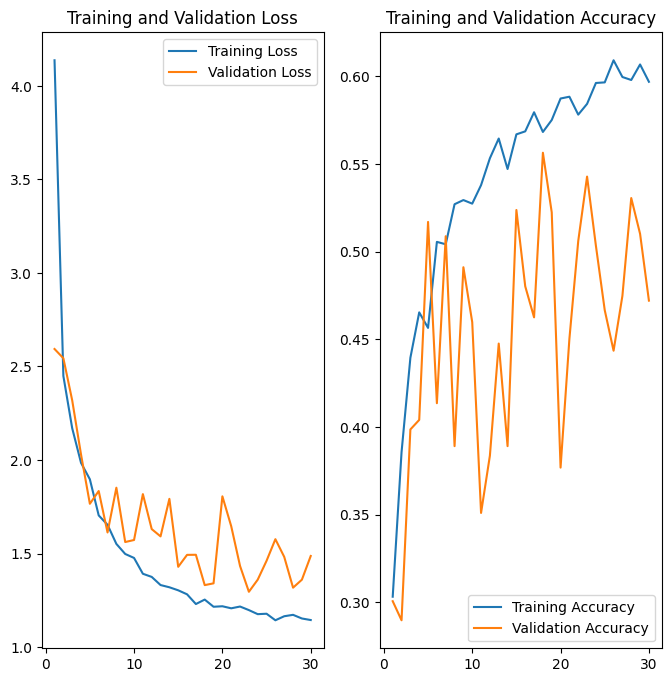

In [23]:
# Visualization of the learning curves
acc = (history.history['accuracy'])
val_acc = (history.history['val_accuracy'])

loss = (history.history['loss'])
val_loss = (history.history['val_loss'])

num_epochs = len(history.epoch)
epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.show()

In [24]:
# Evaluation Best Model
score = base_net.evaluate(val_dataset)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

6/6 [==============================] - 2s 241ms/step - loss: 1.2954 - accuracy: 0.5429
Test loss: 1.2954270839691162
Test accuracy: 0.5428571701049805


### Validation using prediction method

In [25]:
# Inference
yc_pred = base_net.predict(val_dataset)
print('Prediction shape (probability distribution):', yc_pred.shape)

6/6 [==============================] - 3s 297ms/step
Prediction shape (probability distribution): (735, 5)


In [26]:
# Selection of the highest-probability class for each test sample
y_pred = np.argmax(yc_pred, axis=1)

In [27]:
# Retrieving the ground truth classes
yc_test = np.concatenate([y for _, y in val_dataset], axis=0)

In [28]:
y_test = np.argmax(yc_test, axis=1)

In [29]:
accuracy_score(y_test, y_pred)

0.5428571428571428

In [30]:
# Classification report
print('Classification report:')
print(classification_report(y_test, y_pred))

Classification report:
              precision    recall  f1-score   support

           0       0.52      0.50      0.51       127
           1       0.65      0.61      0.63       180
           2       0.77      0.36      0.49       128
           3       0.43      0.59      0.50       140
           4       0.51      0.61      0.55       160

    accuracy                           0.54       735
   macro avg       0.57      0.53      0.54       735
weighted avg       0.57      0.54      0.54       735



Confusion matrix:


Text(0, 0.5, 'Ground truth class')

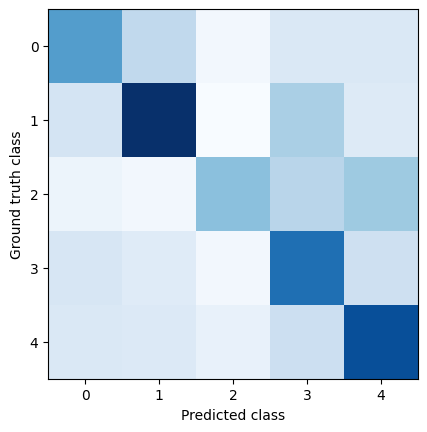

In [31]:
# Confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel('Predicted class')
plt.ylabel('Ground truth class')

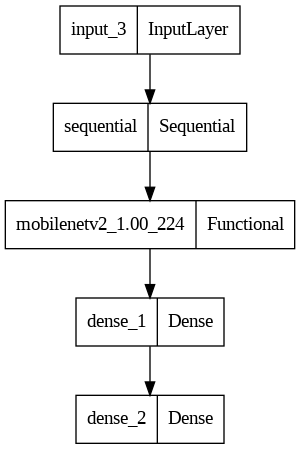

In [32]:
keras.utils.plot_model(base_net)

# Model - Pretrained - BaseNet (V2)

In [52]:
num_classes = 5

In [53]:
# we set an early stopping
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)

#we save only the best model
checkpoint_filepath = 'gdrive/MyDrive/Project_DeepLearning/2_CNN_BaseNet_V2'
mcp_save = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True, monitor='val_loss', mode='min')

In [54]:
# Download Base Model weights
base_net_v2 = keras.applications.MobileNetV2(input_shape=(224,224,3), weights='imagenet', include_top=False, pooling='avg')

In [55]:
# Freezing the base model weights
base_net_v2.trainable = False

In v2 version it has been deleted the regularizer in dense level 1024 and added a new following level 64

In [56]:
# Explicit input layer
inputs = keras.Input((224,224,3))
#x = inputs
x = data_augmentation(inputs)

# Output of the base model
x = base_net_v2(x)

x = keras.layers.Dense(1024, activation='relu')(x)

outputs = keras.layers.Dense(num_classes, activation="softmax")(x)

base_net_v2 = keras.Model(inputs, outputs)

In [57]:
print(base_net_v2.summary())

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       7         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dense_11 (Dense)            (None, 1024)              1311744   
                                                                 
 dense_12 (Dense)            (None, 5)                 5125      
                                                                 
Total params: 3,574,860
Trainable params: 1,316,869
Non-trainable params: 2,257,991
_________________________________________

## Compile & Training - Base.Net Model

In [58]:
# Compile the model for training
base_net_v2.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy'])

In [59]:
# Model training
history = base_net_v2.fit(train_dataset,
          epochs=80,
          validation_data=val_dataset,
          callbacks=[callback, mcp_save]);

Epoch 1/80
23/23 [==============================] - ETA: 0s - loss: 3.1833 - accuracy: 0.3145

23/23 [==============================] - 39s 2s/step - loss: 3.1833 - accuracy: 0.3145 - val_loss: 1.6664 - val_accuracy: 0.3347
Epoch 2/80
23/23 [==============================] - ETA: 0s - loss: 1.4696 - accuracy: 0.4194

23/23 [==============================] - 35s 2s/step - loss: 1.4696 - accuracy: 0.4194 - val_loss: 1.5936 - val_accuracy: 0.3592
Epoch 3/80
23/23 [==============================] - ETA: 0s - loss: 1.4158 - accuracy: 0.4153

23/23 [==============================] - 34s 1s/step - loss: 1.4158 - accuracy: 0.4153 - val_loss: 1.3796 - val_accuracy: 0.4041
Epoch 4/80
23/23 [==============================] - 10s 346ms/step - loss: 1.3563 - accuracy: 0.4572 - val_loss: 1.4167 - val_accuracy: 0.3687
Epoch 5/80
23/23 [==============================] - ETA: 0s - loss: 1.2718 - accuracy: 0.4971

23/23 [==============================] - 34s 1s/step - loss: 1.2718 - accuracy: 0.4971 - val_loss: 1.2997 - val_accuracy: 0.4667
Epoch 6/80
23/23 [==============================] - ETA: 0s - loss: 1.2322 - accuracy: 0.5155

23/23 [==============================] - 34s 1s/step - loss: 1.2322 - accuracy: 0.5155 - val_loss: 1.2766 - val_accuracy: 0.4966
Epoch 7/80
23/23 [==============================] - ETA: 0s - loss: 1.2038 - accuracy: 0.5325

23/23 [==============================] - 34s 1s/step - loss: 1.2038 - accuracy: 0.5325 - val_loss: 1.2166 - val_accuracy: 0.5007
Epoch 8/80
23/23 [==============================] - 10s 372ms/step - loss: 1.1599 - accuracy: 0.5370 - val_loss: 1.2926 - val_accuracy: 0.4517
Epoch 9/80
23/23 [==============================] - 9s 317ms/step - loss: 1.1370 - accuracy: 0.5509 - val_loss: 1.3952 - val_accuracy: 0.4218
Epoch 10/80
23/23 [==============================] - 9s 300ms/step - loss: 1.1613 - accuracy: 0.5356 - val_loss: 1.4229 - val_accuracy: 0.4218
Epoch 11/80
23/23 [==============================] - 10s 384ms/step - loss: 1.1098 - accuracy: 0.5588 - val_loss: 1.3254 - val_accuracy: 0.4844
Epoch 12/80
23/23 [==============================] - 10s 353ms/step - loss: 1.0835 - accuracy: 0.5751 - val_loss: 1.3145 - val_accuracy: 0.4816
Epoch 13/80
23/23 [==============================] - ETA: 0s - loss: 1.0926 - accuracy: 0.5823

23/23 [==============================] - 33s 1s/step - loss: 1.0926 - accuracy: 0.5823 - val_loss: 1.1949 - val_accuracy: 0.5197
Epoch 14/80
23/23 [==============================] - 10s 365ms/step - loss: 1.0888 - accuracy: 0.5693 - val_loss: 1.1985 - val_accuracy: 0.5306
Epoch 15/80
23/23 [==============================] - 9s 337ms/step - loss: 1.0469 - accuracy: 0.5894 - val_loss: 1.2948 - val_accuracy: 0.4857
Epoch 16/80
23/23 [==============================] - ETA: 0s - loss: 1.0389 - accuracy: 0.5741

23/23 [==============================] - 34s 1s/step - loss: 1.0389 - accuracy: 0.5741 - val_loss: 1.1882 - val_accuracy: 0.5279
Epoch 17/80
23/23 [==============================] - 10s 346ms/step - loss: 1.0275 - accuracy: 0.5949 - val_loss: 1.2122 - val_accuracy: 0.5224
Epoch 18/80
23/23 [==============================] - 9s 342ms/step - loss: 1.0136 - accuracy: 0.6068 - val_loss: 1.2359 - val_accuracy: 0.5020
Epoch 19/80
23/23 [==============================] - 9s 296ms/step - loss: 1.0043 - accuracy: 0.6143 - val_loss: 1.2527 - val_accuracy: 0.4884
Epoch 20/80
23/23 [==============================] - 10s 378ms/step - loss: 1.0053 - accuracy: 0.6058 - val_loss: 1.6628 - val_accuracy: 0.3673
Epoch 21/80
23/23 [==============================] - ETA: 0s - loss: 1.0123 - accuracy: 0.6041

23/23 [==============================] - 37s 2s/step - loss: 1.0123 - accuracy: 0.6041 - val_loss: 1.1222 - val_accuracy: 0.5578
Epoch 22/80
23/23 [==============================] - 9s 294ms/step - loss: 1.0006 - accuracy: 0.6211 - val_loss: 1.3105 - val_accuracy: 0.4939
Epoch 23/80
23/23 [==============================] - 10s 371ms/step - loss: 0.9723 - accuracy: 0.6221 - val_loss: 1.2265 - val_accuracy: 0.5265
Epoch 24/80
23/23 [==============================] - 9s 348ms/step - loss: 0.9931 - accuracy: 0.6102 - val_loss: 1.3733 - val_accuracy: 0.4912
Epoch 25/80
23/23 [==============================] - 8s 300ms/step - loss: 0.9633 - accuracy: 0.6259 - val_loss: 1.1461 - val_accuracy: 0.5565
Epoch 26/80
23/23 [==============================] - 10s 356ms/step - loss: 0.9466 - accuracy: 0.6348 - val_loss: 1.2283 - val_accuracy: 0.5116
Epoch 27/80
23/23 [==============================] - 9s 347ms/step - loss: 0.9516 - accuracy: 0.6293 - val_loss: 1.2229 - val_accuracy: 0.5279
Epoch 28/80

In [60]:
# To load the best model
base_net_v2.load_weights(checkpoint_filepath)

## Validation of our Best Model

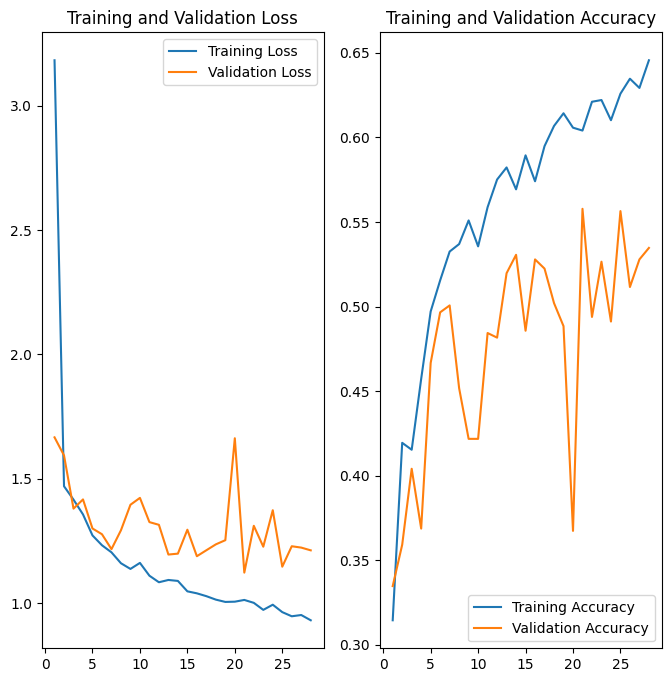

In [61]:
# Visualization of the learning curves
acc = (history.history['accuracy'])
val_acc = (history.history['val_accuracy'])

loss = (history.history['loss'])
val_loss = (history.history['val_loss'])

num_epochs = len(history.epoch)
epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.show()

In [ ]:
# Evaluation Best Model
score = base_net_v2.evaluate(val_dataset)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

6/6 [==============================] - 2s 241ms/step - loss: 1.2954 - accuracy: 0.5429
Test loss: 1.2954270839691162
Test accuracy: 0.5428571701049805


### Validation using prediction method

In [62]:
# Inference
yc_pred = base_net_v2.predict(val_dataset)
print('Prediction shape (probability distribution):', yc_pred.shape)

6/6 [==============================] - 5s 434ms/step
Prediction shape (probability distribution): (735, 5)


In [63]:
# Selection of the highest-probability class for each test sample
y_pred = np.argmax(yc_pred, axis=1)

In [64]:
# Retrieving the ground truth classes
yc_test = np.concatenate([y for _, y in val_dataset], axis=0)

In [65]:
y_test = np.argmax(yc_test, axis=1)

In [66]:
accuracy_score(y_test, y_pred)

0.5578231292517006

In [67]:
# Classification report
print('Classification report:')
print(classification_report(y_test, y_pred))

Classification report:
              precision    recall  f1-score   support

           0       0.44      0.50      0.46       127
           1       0.60      0.68      0.64       180
           2       0.59      0.66      0.63       128
           3       0.49      0.58      0.53       140
           4       0.75      0.36      0.49       160

    accuracy                           0.56       735
   macro avg       0.57      0.56      0.55       735
weighted avg       0.58      0.56      0.55       735



Confusion matrix:


Text(0, 0.5, 'Ground truth class')

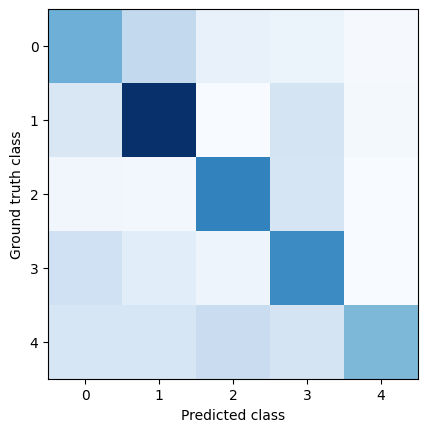

In [68]:
# Confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel('Predicted class')
plt.ylabel('Ground truth class')

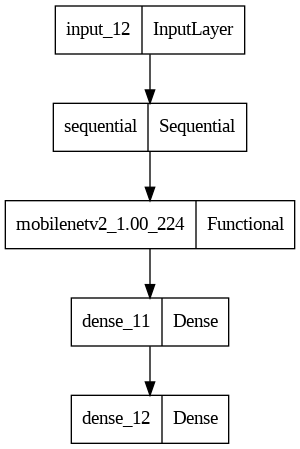

In [69]:
keras.utils.plot_model(base_net_v2)

# Model - Pretrained - BaseNet (V3)

In [70]:
num_classes = 5

In [71]:
# we set an early stopping
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)

#we save only the best model
checkpoint_filepath = 'gdrive/MyDrive/Project_DeepLearning/2_CNN_BaseNet_V3'
mcp_save = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True, monitor='val_loss', mode='min')

In [72]:
# Download Base Model weights
base_net_v3 = keras.applications.MobileNetV2(input_shape=(224,224,3), weights='imagenet', include_top=False, pooling='avg')

In [73]:
# Freezing the base model weights
base_net_v3.trainable = True

In v3 version trainable = True

In [78]:
# Explicit input layer
inputs = keras.Input((224,224,3))
#x = inputs
x = data_augmentation(inputs)

# Output of the base model
x = base_net_v3(x)

x = keras.layers.Dense(1024, activation='relu')(x)
#x = keras.layers.Dense(256, activation='relu')(x)

outputs = keras.layers.Dense(num_classes, activation="softmax")(x)

base_net_v3 = keras.Model(inputs, outputs)

In [79]:
print(base_net_v3.summary())

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       7         
                                                                 
 model_7 (Functional)        (None, 5)                 3833420   
                                                                 
 dense_19 (Dense)            (None, 1024)              6144      
                                                                 
 dense_20 (Dense)            (None, 5)                 5125      
                                                                 
Total params: 3,844,689
Trainable params: 3,810,570
Non-trainable params: 34,119
_________________________________________________________________
None


## Compile & Training - Base.Net Model

In [81]:
# Compile the model for training
base_net_v3.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy'])

In [82]:
# Model training
history = base_net_v3.fit(train_dataset,
          epochs=80,
          validation_data=val_dataset,
          callbacks=[callback, mcp_save]);

Epoch 1/80
23/23 [==============================] - ETA: 0s - loss: 1.4519 - accuracy: 0.3911

23/23 [==============================] - 88s 2s/step - loss: 1.4519 - accuracy: 0.3911 - val_loss: 1.8569 - val_accuracy: 0.2449
Epoch 2/80
23/23 [==============================] - ETA: 0s - loss: 1.1904 - accuracy: 0.4831

23/23 [==============================] - 50s 2s/step - loss: 1.1904 - accuracy: 0.4831 - val_loss: 1.8265 - val_accuracy: 0.3578
Epoch 3/80
23/23 [==============================] - 16s 617ms/step - loss: 1.0602 - accuracy: 0.5162 - val_loss: 2.0669 - val_accuracy: 0.3129
Epoch 4/80
23/23 [==============================] - 16s 636ms/step - loss: 0.9723 - accuracy: 0.5428 - val_loss: 2.4768 - val_accuracy: 0.2612
Epoch 5/80
23/23 [==============================] - 16s 618ms/step - loss: 0.9253 - accuracy: 0.5526 - val_loss: 2.8990 - val_accuracy: 0.1905
Epoch 6/80
23/23 [==============================] - 18s 635ms/step - loss: 0.9079 - accuracy: 0.5523 - val_loss: 3.0436 - val_accuracy: 0.2177
Epoch 7/80
23/23 [==============================] - 16s 608ms/step - loss: 0.8764 - accuracy: 0.5666 - val_loss: 3.2517 - val_accuracy: 0.1755
Epoch 8/80
23/23 [==============================] - 16s 616ms/step - loss: 0.8148 - accuracy: 0.5836 - val_loss: 3.5235 - val_accuracy: 0.1918
Epoch 9/80
23

In [83]:
# To load the best model
base_net_v3.load_weights(checkpoint_filepath)

## Validation of our Best Model

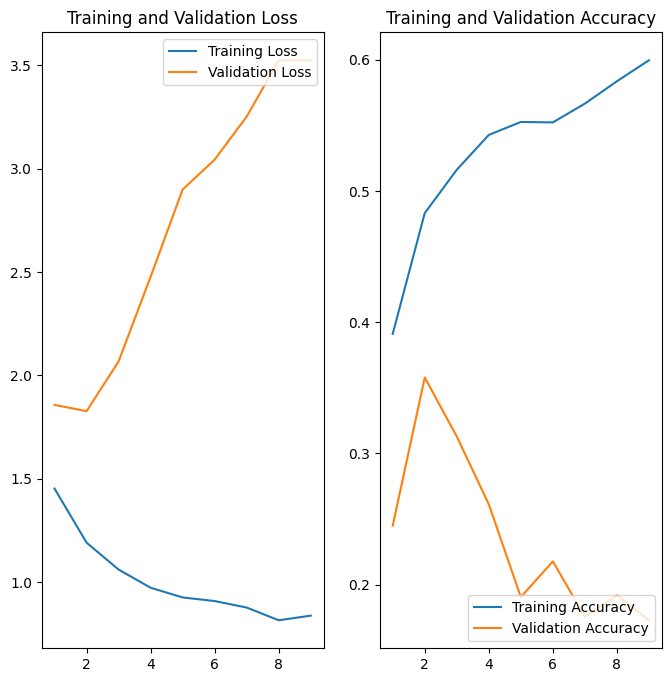

In [84]:
# Visualization of the learning curves
acc = (history.history['accuracy'])
val_acc = (history.history['val_accuracy'])

loss = (history.history['loss'])
val_loss = (history.history['val_loss'])

num_epochs = len(history.epoch)
epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.show()

In [85]:
# Evaluation Best Model
score = base_net_v3.evaluate(val_dataset)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

6/6 [==============================] - 2s 234ms/step - loss: 1.8265 - accuracy: 0.3578
Test loss: 1.8265341520309448
Test accuracy: 0.35782313346862793


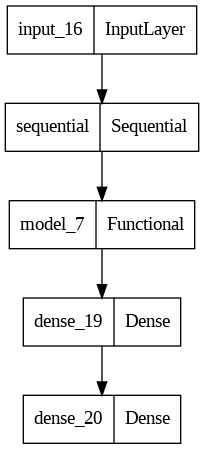

In [86]:
keras.utils.plot_model(base_net_v3)